<a href="https://colab.research.google.com/github/dundurlunka/ml-grand-slam/blob/main/ml_grand_slam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Read data from github

In [46]:
import pandas as pd
import numpy as np

import sys
import csv

In [47]:
csv.field_size_limit(sys.maxsize)

points = pd.read_csv('./charting-m-points-from-2017.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')
matches = pd.read_csv('./charting-m-matches.csv', quoting=csv.QUOTE_NONE, encoding = 'ISO-8859-1')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8,9,29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Merge the two datasets together by match_id

In [48]:
joinedData = pd.merge(
    matches,
    points,
    how="inner",
    on='match_id',
)

In [49]:
df_obj = joinedData.select_dtypes(['object'])
joinedData[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

Select relevant columns from dataframe


In [50]:
joinedData.columns = joinedData.columns.to_series().apply(lambda x: x.strip())
joinedData = joinedData.loc[:, ['Player 1', 'Player 2', 'Tournament', 'Pl 1 hand', 'Pl 2 hand', 'Surface', 'Set1','Set2', 'Gm1', 'Gm2', 'Pts', 'Serving', '1st', '2nd', 'isAce', 'isUnret']]

In [51]:
joinedData['isAce'] = joinedData['isAce'] | joinedData['isUnret']
joinedData = joinedData.drop(columns=['isUnret', 'isAce'])

In [52]:
tennis_players = ['Daniil Medvedev', 'Alexander Zverev', 'Roger Federer', 'Dominic Thiem', 'Nick Kyrgios', 'Novak Djokovic', 'Rafael Nadal', 'Stefanos Tsitsipas', 'Casper Ruud', 'Grigor Dimitrov']
tennis_players_initials = [''.join([x[0].upper() for x in fullname.split(' ')]) for fullname in tennis_players]
joinedData = joinedData.loc[((joinedData['Player 1'].isin(tennis_players)) | (joinedData['Player 2'].isin(tennis_players)))]
joinedData = joinedData.loc[joinedData['Serving'].isin(tennis_players_initials)]

In [53]:
joinedData[['Pts1', 'Pts2']] = joinedData['Pts'].str.split('-', expand=True)
joinedData = joinedData.drop('Pts', axis='columns')

Separate the columns into new columns that are specific for Server and Returner.

In [54]:
server_names = []
returner_names = []
pointsServer = []
pointsReturner = []
gamesServer = []
gamesReturner = []
setsServer = []
setsReturner = []
handReturner = []
for index, row in joinedData.iterrows():
    if ''.join([x[0].upper() for x in row['Player 1'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 1'])
      returner_names.append(row['Player 2'])
      pointsServer.append(row['Pts1'])
      pointsReturner.append(row['Pts2'])
      gamesServer.append(row['Gm1'])
      gamesReturner.append(row['Gm2'])
      setsServer.append(row['Set1'])
      setsReturner.append(row['Set2'])
      handReturner.append(row['Pl 2 hand'])
    elif ''.join([x[0].upper() for x in row['Player 2'].split(' ')]) == row['Serving']:
      server_names.append(row['Player 2'])
      returner_names.append(row['Player 1'])
      pointsServer.append(row['Pts2'])
      pointsReturner.append(row['Pts1'])
      gamesServer.append(row['Gm2'])
      gamesReturner.append(row['Gm1'])
      setsServer.append(row['Set2'])
      setsReturner.append(row['Set1'])
      handReturner.append(row['Pl 1 hand'])

joinedData['FullNameServer'] = server_names
joinedData['FullNameReturner'] = returner_names
joinedData['PointsServer'] = pointsServer
joinedData['PointsReturner'] = pointsReturner
joinedData['GamesServer'] = gamesServer
joinedData['GamesReturner'] = gamesReturner
joinedData['SetsServer'] = setsServer
joinedData['SetsReturner'] = setsReturner
joinedData['HandReturner'] = handReturner

joinedData = joinedData.drop(columns=['Player 1', 'Player 2', 'Pts1', 'Pts2', 'Gm1', 'Gm2', 'Set1', 'Set2', 'Pl 1 hand', 'Pl 2 hand', 'Serving'])

Combine the serves into one column with a list of 1 or 2 serves so that it can be exploded into several rows later

In [55]:
joinedData['Serves'] = joinedData.apply(lambda x: list(['f' + str(x['1st']),
                                                        's' + str(x['2nd'])]), axis=1)   

Explode list of first and second serve into separate rows

In [56]:
joinedData = joinedData.explode('Serves')

Add new column indicating whether the serve was first or second

In [57]:
joinedData['IsFirstServe'] = joinedData['Serves'].str[0] == 'f'

Remove 'f' and 's' (first and second serve) that were indicators before the explosion

In [58]:
joinedData['Serves'] = joinedData['Serves'].str[1:]
joinedData = joinedData[(joinedData['Serves'] != 'nan') & (joinedData['Serves'] != '')]
joinedData = joinedData.drop(columns=['1st', '2nd'])

Remove lets

In [59]:
joinedData['Serves'] = joinedData['Serves'].map(lambda x: x.lstrip('c'))

In [60]:
joinedData['FullNameServer'].value_counts()
joinedData['FullNameReturner'].value_counts()

Novak Djokovic                 5698
Rafael Nadal                   4634
Stefanos Tsitsipas             4454
Daniil Medvedev                4011
Alexander Zverev               3736
Dominic Thiem                  3489
Roger Federer                  3283
Nick Kyrgios                   3249
Matteo Berrettini              2007
Andrey Rublev                  1950
Juan Martin Del Potro          1818
Marin Cilic                    1725
Stan Wawrinka                  1687
Denis Shapovalov               1651
Hubert Hurkacz                 1546
David Goffin                   1518
Grigor Dimitrov                1505
Diego Schwartzman              1398
Borna Coric                    1358
Carlos Alcaraz                 1341
Jannik Sinner                  1294
Felix Auger Aliassime          1267
Taylor Fritz                   1155
Gael Monfils                   1063
John Isner                     1059
Milos Raonic                   1034
Karen Khachanov                1026
Botic Van De Zandschulp     

Extract direction of serve

In [61]:
def extract_serve_direction(row):
  serves_directions_dict = {
      '4': 1,
      '5': 1,
      '6': 1
  }

  if len(row['Serves']) > 1 and row['Serves'][1] in ['x', 'd', 'w', 'n', 'g', '!', 'e']:
      return 0
  else:
      return serves_directions_dict.get(row['Serves'][0], 1)

joinedData['Direction'] = joinedData.apply(extract_serve_direction, axis=1)
joinedData = joinedData.drop(columns='Serves')

## Remove faults from dataframe

In [62]:
joinedData.to_csv('wrangled-data.csv')

# Start of machine learning

### Data exploration

In [63]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [64]:
joinedData = pd.read_csv('./wrangled-data.csv')
joinedData = joinedData.drop(columns=['Unnamed: 0'])
pd.set_option('display.max_rows', 500)
joinedData.head(500)

,Tournament,Surface,FullNameServer,FullNameReturner,PointsServer,PointsReturner,GamesServer,GamesReturner,SetsServer,SetsReturner,HandReturner,IsFirstServe,Direction
0,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,0,0,R,True,0
1,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,0,0,0,0,0,R,False,1
2,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,15,0,0,0,0,R,True,0
3,Tour Finals,Hard,Novak Djokovic,Casper Ruud,0,15,0,0,0,0,R,False,1
4,Tour Finals,Hard,Novak Djokovic,Casper Ruud,15,15,0,0,0,0,R,True,1
5,Tour Finals,Hard,Novak Djokovic,Casper Ruud,30,15,0,0,0,0,R,True,0
6,Tour Finals,Hard,Novak Djokovic,Casper Ruud,30,15,0,0,0,0,R,False,1
7,Tour Finals,Hard,Novak Djokovic,Casper Ruud,40,15,0,0,0,0,R,True,1
8,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,0,0,1,0,0,R,True,0
9,Tour Finals,Hard,Casper Ruud,Novak Djokovic,0,0,0,1,0,0,R,False,1


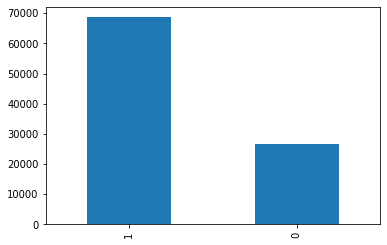

In [65]:
joinedData['Direction'].value_counts().plot(kind='bar')

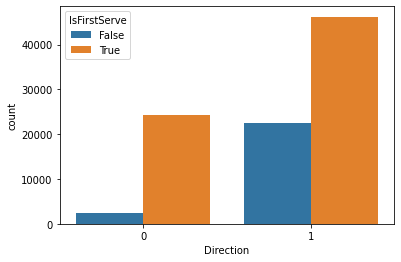

In [66]:
sns.countplot(
    x = 'Direction',
    hue = 'IsFirstServe',
    data = joinedData,
)

## Pre-processing

In [67]:
X = joinedData.drop(columns=['Direction'])
y = joinedData['Direction']

### One hot encoding attributes

In [68]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

categorical_columns = ['Surface', 'FullNameServer', 'FullNameReturner', 'PointsServer', 'PointsReturner', 'HandReturner', 'Tournament']

encoded_X = pd.get_dummies(X, columns=categorical_columns)

In [69]:
encoded_X.to_csv('encoded_attributes.csv')

### Label encoding the label

In [70]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
encoded_y = le.fit_transform(y)

### Splitting into train test

In [71]:
X_train, X_test, y_train, y_test = train_test_split(encoded_X, encoded_y)

## MinMax Scaling

In [75]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

scaler = MinMaxScaler()
scaler.fit(encoded_X)
scaled_encoded_X_train = scaler.transform(X_train)
scaled_encoded_X_test = scaler.transform(X_test)

regression = LogisticRegression(C=20, max_iter=10000).fit(scaled_encoded_X_train, y_train)

train_score = regression.score(scaled_encoded_X_train, y_train)
test_score = regression.score(scaled_encoded_X_test, y_test)

print(f'train score: {train_score}')
print(f'test score: {test_score}')

train score: 0.7206571784429797
test score: 0.7184180696082959


In [76]:
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


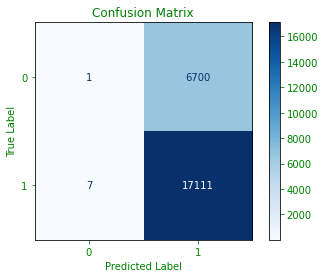

In [78]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
 
color = 'green'
matrix = plot_confusion_matrix(regression, X_test, y_test, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()


In [79]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.00      0.00      6701
           1       0.72      1.00      0.84     17118

    accuracy                           0.72     23819
   macro avg       0.42      0.50      0.42     23819
weighted avg       0.55      0.72      0.60     23819



In [84]:
unique, counts = np.unique(y_test, return_counts=True)
print(unique, counts)

[0 1] [ 6701 17118]


In [ ]:
pd.set_option('display.max_rows', 500)
joinedData.head(500)

## KNN

In [ ]:
def plot_knn_scores(ks):
    train_scores = []
    test_scores = []
    
    for k in ks:
        clf = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)

        print('finding scores for ' + str(k) + ' k neares neighbours')

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)              

        print('found scores for ' + str(k) + ' k neares neighbours\n' + f'train_score: {train_score}\n' + f'test_score: {test_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(ks, train_scores, color='blue', label='train score')
    plt.plot(ks, test_scores, color='green', label='test score')
    plt.legend()

In [ ]:
plot_knn_scores(range(1, 15, 2))

## Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression, OneVsRestClassifier

def plot_logistic_regression_scores(cs):
    train_scores = []
    test_scores = []
    
    for c in cs:
        regression = OneVsRestClassifier(LogisticRegression(C=c)).fit(encoded_X_train, encoded_y_train)

        print(f'finding scores for c={c}')

        train_score = regression.score(X_train, y_train)
        test_score = regression.score(X_test, y_test)              

        print(f'found train score for c={c}: {train_score}')

        train_scores.append(train_score)
        test_scores.append(test_score)

    plt.figure(figsize=(10, 6))
    plt.plot(cs, train_scores, color='blue', label='train score')
    plt.plot(cs, test_scores, color='green', label='test score')
    plt.legend()

In [ ]:
plot_logistic_regression_scores([0.001, 0.01, 0.1, 1, 10, 1000, 10000])

In [ ]:
# pd.set_option('display.max_rows', 500)
# joinedData.head(500)

In [ ]:
import numpy as np
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

std_slc = StandardScaler()
pca = decomposition.PCA()
logistic_Reg = linear_model.LogisticRegression()

pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('logistic_Reg', logistic_Reg)])

n_components = list(range(1,encoded_X.shape[1]+1,1))

C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

parameters = dict(pca__n_components=n_components,
                      logistic_Reg__C=C,
                      logistic_Reg__penalty=penalty)

clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, y)

print('Best Penalty:', clf_GS.best_estimator_.get_params()['logistic_Reg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logistic_Reg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['logistic_Reg'])